In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
bio = pd.read_csv("../../dataset/Agriculture_biologique_final.csv", sep ="\t")
env = pd.read_csv("../../dataset/Impact environnemental_final.csv", sep="\t",low_memory=False)
qual = pd.read_csv("../../dataset/Qualite nutritionnelle_final.csv", sep="\t",low_memory=False)

# 0  Nettoyage

Nettoyage de env : 

In [4]:
env.drop_duplicates(inplace=True)

In [5]:
env_brand_missing = env.loc[env.brands_tags.isnull()].index
env_Wmarques= env.drop(index=env_brand_missing)

Nettoyage de qual : 

In [100]:
qual.drop_duplicates(inplace=True)

In [101]:
qual_brand_missing = qual.loc[qual.brands_tags.isnull()].index
qual_Wmarques= qual.drop(index=qual_brand_missing)

## 0.1 Regroupement des datasets

Colonnes communes env & qual

Merge des df env et qual

In [3]:
envqual = env.merge(qual, on = ['code', 'product_name', 'quantity', 'brands_tags', 'countries_tags','serving_size', 'image_url'], how='outer', indicator='merged_qual')

Colonnes communes envqual et bio

Merge des df env et qual

In [4]:
envqualbio = envqual.merge(bio, on=['product_name', 'brands_tags', 'serving_size'], how='outer', indicator='merged_bio')

On supprime les doublons

In [5]:
envqualbio = envqualbio.drop_duplicates()

In [6]:
envqualbio.reset_index(inplace=True)

In [7]:
envqualbio.drop(columns='index',inplace=True)

Gestion des valeurs manquantes

Pourcentage des valeurs manquantes par colonnes

In [8]:
envqualbio.isnull().sum()

code                       0
product_name           24354
quantity              579572
brands_tags           412045
countries_tags             0
serving_size          763369
image_url              71750
ecoscore_grade           662
est_plastique              0
est_palm                   0
est_cocoa                  0
ingredients_tags      596585
nutriscore_grade      543571
energy-kcal_100g      215440
fat_100g              197506
saturated-fat_100g    192288
sugars_100g           192913
proteins_100g         195686
salt_100g             222287
nb_nocif                   0
merged_qual                0
est_bio               412045
merged_bio                 0
dtype: int64

In [9]:
envqualbio.shape

(849616, 23)

 Pourcentage de données nulles du tableau

In [10]:
envqualbio.isnull().sum() / envqualbio.shape[0] * 100

code                   0.000000
product_name           2.866471
quantity              68.215759
brands_tags           48.497792
countries_tags         0.000000
serving_size          89.848708
image_url              8.444992
ecoscore_grade         0.077918
est_plastique          0.000000
est_palm               0.000000
est_cocoa              0.000000
ingredients_tags      70.218193
nutriscore_grade      63.978433
energy-kcal_100g      25.357338
fat_100g              23.246502
saturated-fat_100g    22.632342
sugars_100g           22.705905
proteins_100g         23.032288
salt_100g             26.163231
nb_nocif               0.000000
merged_qual            0.000000
est_bio               48.497792
merged_bio             0.000000
dtype: float64

In [11]:
ind_brand_missing = envqualbio.loc[envqualbio.brands_tags.isnull()].index
df_Wmarques= envqualbio.drop(index=ind_brand_missing)

# Quelles sont les marques qui jouent le jeu et affichent le nutriscore ? Lesquelles ne le font pas?

# Quelles sont les marques qui ont le plus recours aux additifs nocifs ?

In [120]:
ten_worst_nocive_brands = qual_Wmarques.groupby('brands_tags').nb_nocif.sum().sort_values(ascending=False)[:10]
ten_worst_nocive_brands

brands_tags
sodastream          29.0
nestle,sveltesse    10.0
a-rom                9.0
dove                 8.0
nestle               7.0
schweppes            7.0
freeway              6.0
steff                4.0
fruiss               4.0
san-benedetto        4.0
Name: nb_nocif, dtype: float64

Les 10 marques ayant le plus recours aux additifs nocifs

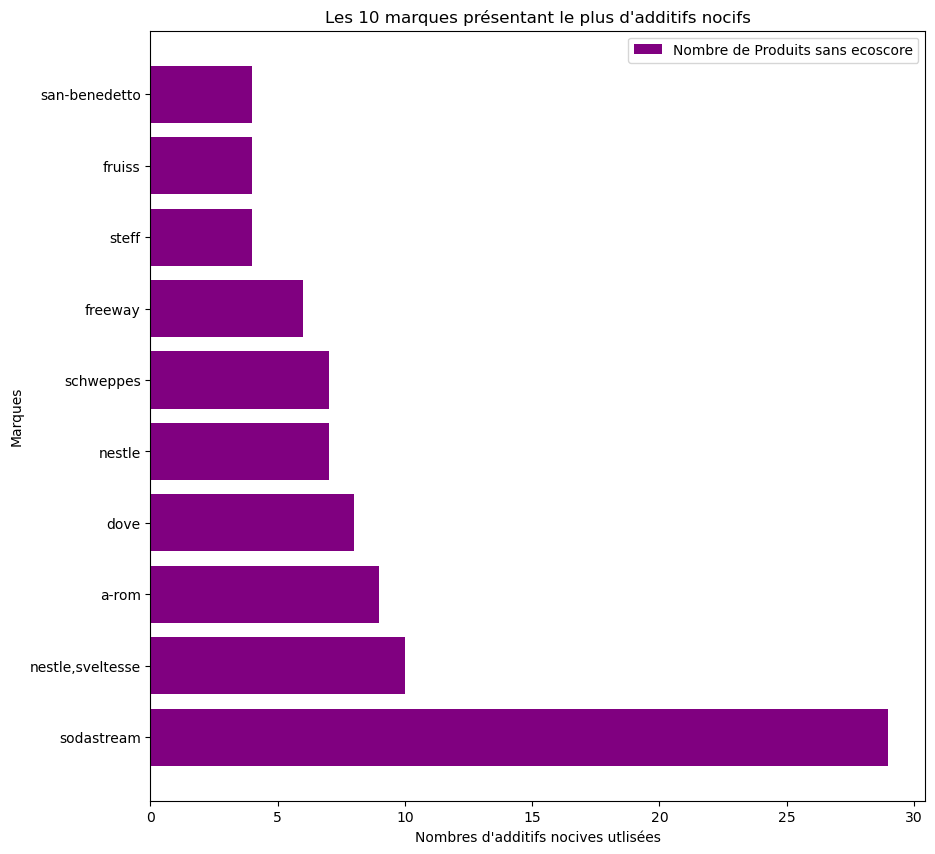

In [122]:
plt.figure(figsize=(10,10))
plt.barh(y = ten_worst_nocive_brands.index  , color='purple', width=ten_worst_nocive_brands)
plt.ylabel('Marques')
plt.xlabel("Nombres d'additifs nocives utlisées")
plt.title("Les 10 marques présentant le plus d'additifs nocifs")
plt.legend(labels=['Nombre de Produits sans ecoscore','Nombre de produits de la marque'])
plt.show()

# Quelles sont les marques qui jouent le jeu et affichent l'ecoscore ? Lesquelles ne le font pas?

Afin de déterminer quelles marques jouent le jeu de celles qu'ils ne le font pas, on différencie ici les marques en 2 groupes : <br>
- Les "grandes" marques ayant un nombre de produit "important"
- Les "petites" marques qui auront peu de proposés

## Définition d'un seuil de nombre de produit par marque

In [72]:
seuil = env_Wmarques.groupby('brands_tags').product_name.count().quantile([0.98]).values[0]
marques_p = (env_Wmarques.groupby('brands_tags').product_name.count() >= seuil).index
marques_pte = (env_Wmarques.groupby('brands_tags').product_name.count() < seuil).index
df_gdemarq = env_Wmarques[env_Wmarques.brands_tags.isin(marques_p)]
df_ptemarq = env_Wmarques[env_Wmarques.brands_tags.isin(marques_pte)]

## X.1 Ecoscore des "grandes" marques

### X.1.1 Présence de l'Ecoscore dans les produits de la Marque 

#### Quels sont les "bons" élèves ? 

##### Marques présentant la meilleure présence d'ecoscore 

In [73]:
count_nut_W = df_gdemarq.brands_tags.loc[df_gdemarq.ecoscore_grade.isin(['d','c', 'b', 'not-applicable', 'a', 'e'])].value_counts()[:10]

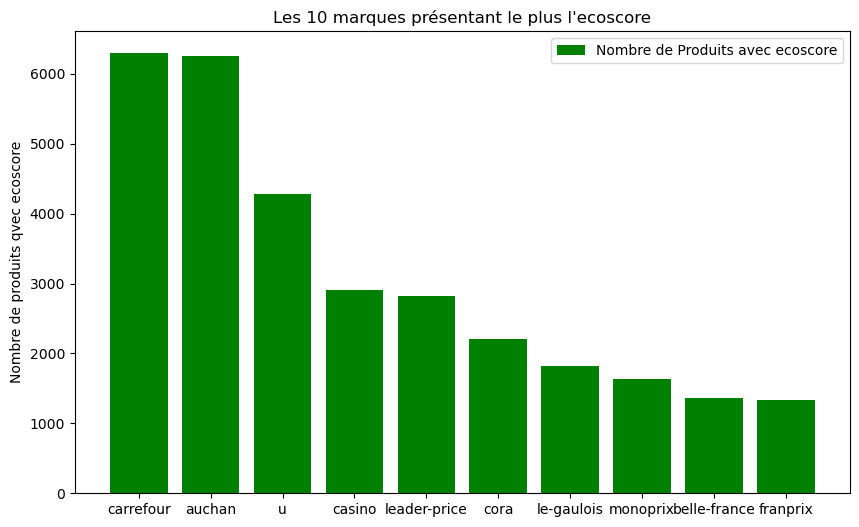

In [74]:
plt.figure(figsize=(10,6))
plt.bar(x = count_nut_W.index , height = count_nut_W, color='g')
plt.ylabel('Nombre de produits qvec ecoscore')
plt.title('Les 10 marques présentant le plus l\'ecoscore')
plt.legend(labels=['Nombre de Produits avec ecoscore','Nombre de produits de la marque'])
plt.show()

##### Marques qui utilisent le plus l'ecoscore

In [75]:
ratio_eco_good = (count_nut_W[:10] / df_gdemarq.brands_tags[df_gdemarq.brands_tags.isin(count_nut_W[:10].index)].value_counts()).sort_values(ascending=False)

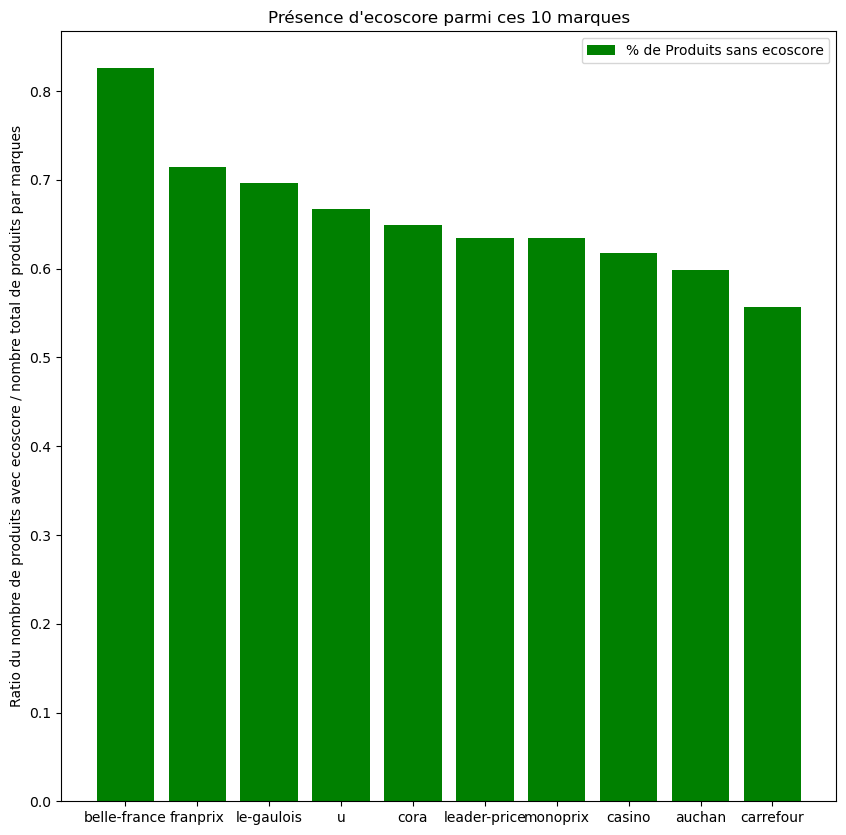

In [77]:
plt.figure(figsize=(10,10))
plt.bar(x = ratio_eco_good.index , height = ratio_eco_good, color='g')
plt.ylabel('Ratio du nombre de produits avec ecoscore / nombre total de produits par marques')
plt.title("Présence d'ecoscore parmi ces 10 marques")
plt.legend(labels=['% de Produits sans ecoscore'])
plt.show()

#### Quels sont les "mauvais" élèves ? 

##### Marques présentant le plus d'absence d'ecoscore 

In [80]:
count_nut_miss = df_gdemarq.brands_tags.loc[(df_gdemarq.ecoscore_grade.isin(['unknown'])) | (df_gdemarq.ecoscore_grade.isnull()) ].value_counts().sort_values(ascending=False)[:10]
count_nut = df_gdemarq.brands_tags.loc[df_gdemarq.brands_tags.isin(count_nut_miss.index)].value_counts()

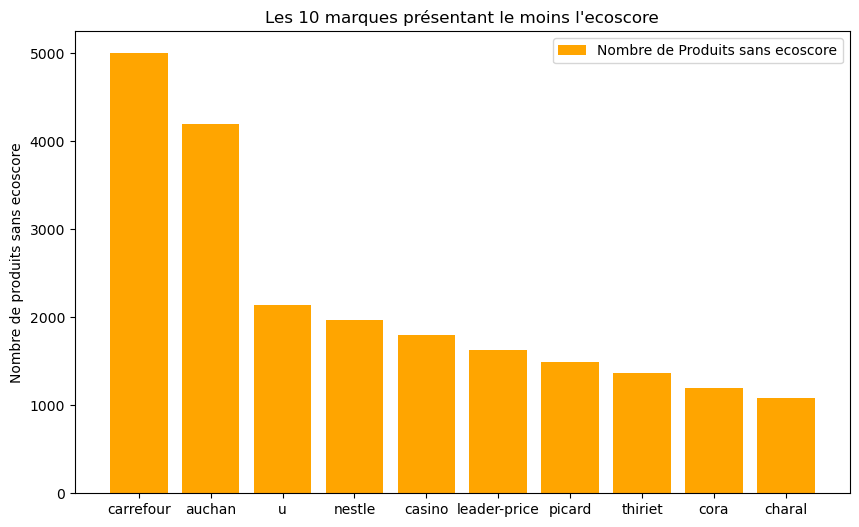

In [81]:
plt.figure(figsize=(10,6))
plt.bar(x = count_nut_miss.index , height = count_nut_miss, color='orange')
plt.ylabel('Nombre de produits sans ecoscore')
plt.title('Les 10 marques présentant le moins l\'ecoscore')
plt.legend(labels=['Nombre de Produits sans ecoscore','Nombre de produits de la marque'])
plt.show()

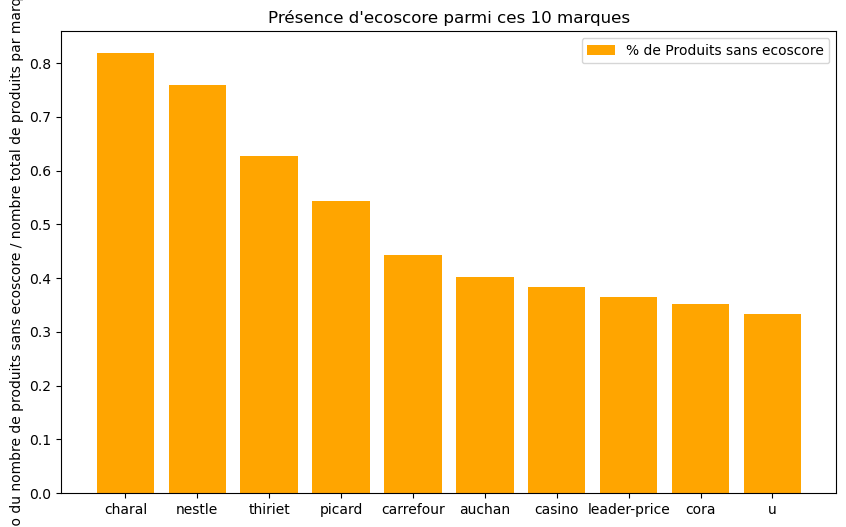

In [82]:
ratio_eco_brand = (count_nut_miss / count_nut).sort_values(ascending=False)
plt.figure(figsize=(10,6))
plt.bar(x = ratio_eco_brand.index , height = ratio_eco_brand, color='orange')
plt.ylabel('Ratio du nombre de produits sans ecoscore / nombre total de produits par marques')
plt.title("Présence d'ecoscore parmi ces 10 marques")
plt.legend(labels=['% de Produits sans ecoscore'])
plt.show()

##### Marques qui utilisent le moins l'ecoscore

In [83]:
count_nut_miss_p = df_gdemarq.brands_tags.loc[(df_gdemarq.ecoscore_grade.isin(['unknown'])) | (df_gdemarq.ecoscore_grade.isnull()) ].value_counts()
count_nut_p = df_gdemarq.brands_tags.value_counts()
ratio_ecoscore_presence  = (count_nut_miss_p /count_nut_p).sort_values(ascending=False)

Pourcentage d'absence d'ecoscore 

In [84]:
p_gde_ecoMiss = df_gdemarq.loc[df_gdemarq.ecoscore_grade.isin(['d','c', 'b', 'not-applicable', 'a', 'e'])].ecoscore_grade.count() /df_gdemarq.ecoscore_grade.count() * 100

In [85]:
nb_miss_gde = df_gdemarq.loc[(df_gdemarq.ecoscore_grade.isin(['unknown'])) | (df_gdemarq.ecoscore_grade.isnull())].groupby('brands_tags').ecoscore_grade.count() / df_gdemarq.groupby('brands_tags').ecoscore_grade.count()
nb_miss_gde.std() * 100

26.08602045093943

### X.2 Présence Ecoscore des "petites" marques 

Au vu du nombre de produits de ces marques, on ne va pas essayer de tirer des conclusions pour chacune d'elles mais on va essayer de voir s'il on retrouve une tendance parmi celles-ci.

In [22]:
p_nut_miss_pte = df_ptemarq.loc[(df_ptemarq.ecoscore_grade.isin(['unknown'])) | (df_ptemarq.ecoscore_grade.isnull()) ].brands_tags.count() / df_ptemarq.ecoscore_grade.count() * 100
p_nut_miss_pte

51.12772886262212

In [23]:
nb_miss = df_ptemarq.loc[(df_ptemarq.ecoscore_grade.isin(['unknown'])) | (df_ptemarq.ecoscore_grade.isnull())].groupby('brands_tags').ecoscore_grade.count() / df_ptemarq.groupby('brands_tags').ecoscore_grade.count()
nb_miss.std() * 100

26.08602045093943

## X. Bilan 

Comparaison % présence  nutriscore pte marques / gde marques <br>
Grandes marques : bonnes et mauvaises élèves

Grandes Marques affichant leur nutriscore : <br>
- 1. belle-france 
- 2. franprix 
- 3. le-gaulois
- 4. u 
- 5. cora 
- 6. leader-price
- 7. monoprix
- 8. casino
- 9. auchan 
- 10. carrefour

Grandes Marques jouant moins le moins le jeu : <br>
- 1. charal
- 2. nestle 
- 3. thiriet
- 4. picard
- 5. carrefour
- 6. auchan
- 7. casino
- 8. leader-price
- 9. cora
- 10. u

Dans l'affichage de l'ecoscore, observe-t-on une différence entre les grandes marques, des petites ? 

[Text(0, 0, '51.1277'), Text(0, 0, '48.8871')]

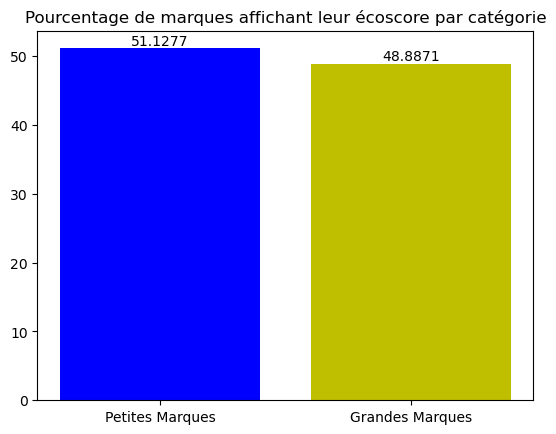

In [33]:
fig, ax = plt.subplots()
bars = ax.bar(['Petites Marques','Grandes Marques'], [p_nut_miss_pte,p_gde_ecoMiss], color = ['b','y'])
plt.title('Pourcentage de marques affichant leur écoscore par catégorie')
ax.bar_label(bars)

# Quelles sont les marques qui semblent le plus respectueuses de l'environnement ? le moins?

On procède de la même manière que pour l'ecoscore , en séparant les grandes marques des petites. <br>

## Ecoscore global des produits

Text(0.5, 0, "Notes d'ecoscore")

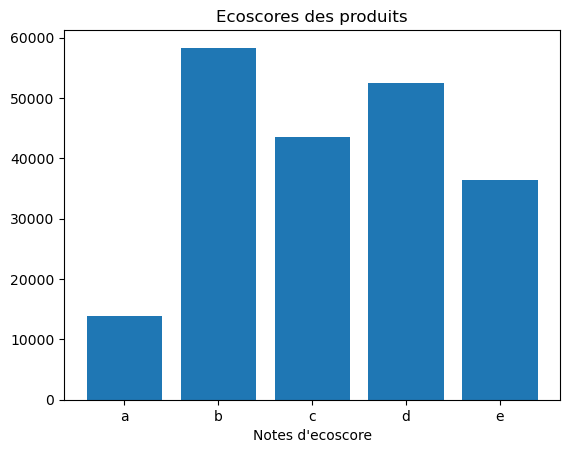

In [86]:
plt.bar(x= ['a','b','c','d','e'], height= env_Wmarques[env_Wmarques.isin(['a','b','c','d','e'])].groupby('ecoscore_grade').ecoscore_grade.count())
plt.title('Ecoscores des produits')
plt.xlabel("Notes d'ecoscore")

## Le respect de l'environnement pour les grandes marques 

In [87]:
col_indicatrice= ['brands_tags','est_plastique','ecoscore_grade','est_palm','est_cocoa']
df_env_indic = df_gdemarq[col_indicatrice]

In [88]:
# on drop les colonnes où l'ecoscore n'est pas applicable et où il est nul 
ind_notapp = df_env_indic.loc[df_env_indic.ecoscore_grade == 'not-applicable'].index
df_env_indic = df_env_indic.drop(index = ind_notapp)
df_env_indic.ecoscore_grade.dropna(inplace=True)

In [89]:
def ord_eco(x):
    if x == 'a':
        return 0
    elif x == 'b':
        return 1
    elif x == 'c':
        return 2
    elif x == 'd':
        return 3
    else:
        return 4
df_env_indic["eco_ord"] = df_env_indic.ecoscore_grade.map(ord_eco)

Pour les produits grandes marques, on relève un ecoscore moyen de 3.13 ce qui équivaut à une note moyenne de d. Avec un écart-type de 1.23, les ecoscores sont donc majoritairement concentrés vers d. <br>
Une majorité donc de produit a un écoscore relativement faible.

Si on s'interesse, à l'ecoscore non plus global mais moyen par marque on peut observer une distribution assez disparate : <br>
Puisque la moitié des grandes marques ont un ecoscore moyen supérieur à 3.7 .<br>
La moyenne est donc pondérée par l'inégalité des ecoscores.

Text(0, 0.5, 'Ecoscore moyen')

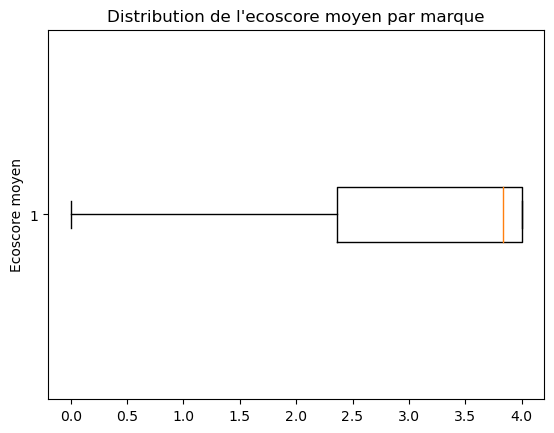

In [90]:
plt.boxplot(df_env_indic.groupby('brands_tags').eco_ord.mean(), vert= False)
plt.title('Distribution de l\'ecoscore moyen par marque')
plt.ylabel('Ecoscore moyen')

### Les grandes marques ayant le moins bon ecoscore moyen 

In [91]:
worst = pd.DataFrame(df_env_indic.groupby('brands_tags').eco_ord.mean().sort_values(ascending=False)[:10])
worst.index

Index(['0', 'les-p-tits-fermiers-chevrerie-becot', 'les-nougats-stanislas',
       'les-nouveaux-affineurs', 'les-nouveaux-fermiers',
       'les-nouveaux-robinsons', 'les-oeufs-degustation,cemoi',
       'les-olives-du-mont-bouquet', 'les-oreades-des-beauges',
       'les-originelles'],
      dtype='object', name='brands_tags')

In [92]:
best = df_env_indic.groupby('brands_tags').eco_ord.mean().sort_values(ascending=True)[:10]

## Le respect de l'environnement pour les petites marques 

In [93]:
df_env_indic_pte = df_ptemarq[col_indicatrice]
ind_notapp_pte = df_env_indic_pte.loc[df_env_indic_pte.ecoscore_grade == 'not-applicable'].index
df_env_indic_pte = df_env_indic_pte.drop(index = ind_notapp_pte)
df_env_indic_pte.ecoscore_grade.dropna(inplace=True)
df_env_indic_pte["eco_ord"] = df_env_indic_pte.ecoscore_grade.map(ord_eco)

In [94]:
df_env_indic_pte.eco_ord.mean()

3.1300265826060363

In [95]:
df_env_indic_pte.eco_ord.std()

1.2375875263252196

##  Bilan 

Les marques avec le pire ecoscore moyen  : <br>
- 1. les-p-tits-fermiers-chevrerie-becot
- 2. les-nougats-stanislas
- 3. les-nouveaux-affineurs
- 4. les-nouveaux-fermiers
- 5. les-nouveaux-robinsons
- 6. les-oeufs-degustation,cemoi
- 7. les-olives-du-mont-bouquet
- 8. les-oreades-des-beauges
- 9. les-originelles 

Les marques avec le pire ecoscore moyen  : <br>
- 1. dara-fruits
- 2. oh-my-tea
- 3. luxoheal
- 4. tetemoire
- 5. tetley,tata-global-beverages
- 6. charles-ming
- 7. charitea,charitea-green
- 8. m-cantaloube
- 9. m-de-turenne,qualite-choix,socoboma

Text(0.5, 1.0, 'Ecoscore moyen pour les 2 catégories de marques')

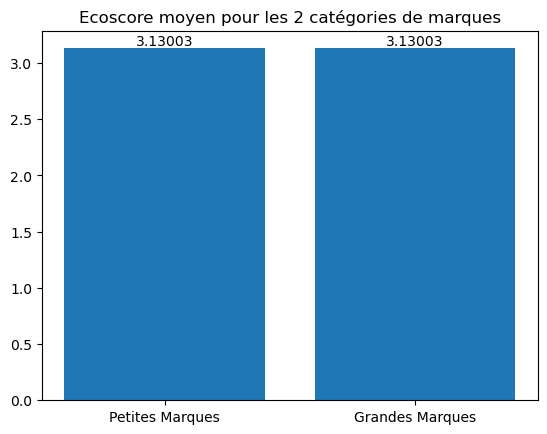

In [96]:
fig, ax = plt.subplots()
bars = ax.bar(['Petites Marques','Grandes Marques'], [df_env_indic_pte.eco_ord.mean(),df_env_indic.eco_ord.mean()])
ax.bar_label(bars)
plt.title('Ecoscore moyen pour les 2 catégories de marques')

## Création d'un nouvel indice 

Alors que l'ecoscore prend en compte différents critères ( voir : docs.score-environnemental.com ) <br>
Il ne prend pas en compte si un produit contient de l'huile de palme ou s'il a du plastique (...) <br>
La démarche est donc de redéfinir une nouvelle note afin d'obtenir un score plus proche de la réalité. <br>
A savoir qu'un nouvel ecoscore, l'ecobalyse qui comprend de nouveaux critères est actuellement en phase de test pour être déployé en 2024 . <br>
(lien : https://www.ecologie.gouv.fr/affichage-environnemental-des-produits-alimentaires-berangere-couillard-presente-projet-methode ) 

partie test à retirer ? 

Création d'un nouvel indice, une note qui prend en compte pour un produit : <br>
- Son Ecoscore <br>
- Si il est en plastique <br>
- Si il contient de l'huile de palme <br>
- Si il contient du cacao <br>

In [60]:
df_env_indic["score_env"] = df_env_indic.eco_ord + df_env_indic.est_plastique + df_env_indic.est_palm + df_env_indic.est_cocoa
df_env_indic.groupby("brands_tags").score_env.mean().sort_values(ascending=False).head(10).index

Index(['kinder,ferrero,ferrero-france', 'terry-s,mondelez',
       'kinder,ferrero,schoko-bons', 'bon-bon-buddies,universal', 'alwadi',
       'ferrero,nutella,ferrero-nutella,ferrero-nutella-ferrero-nutella,ferrero-nutella-ferrero-nutella-ferrero-nutella-ferrero-nutella',
       'nature-et-decouvertes,nature-decouvertes,dolfin', 'chocotime',
       'auchan,polegar', 'savon-de-france'],
      dtype='object', name='brands_tags')

On peut le comparer à la moyenne qui est de : 1.6972031376039614 points

In [196]:
df_env_indic["score_env"].std()

1.2642389656860575

In [192]:
df_env_indic.brands_tags.loc[df_env_indic.score_env == 0 ].count()  

12183

12 324 marques ont une moyene de score environnemental de 0. 

In [188]:
df_env_indic.groupby("brands_tags").score_env.mean().sort_values(ascending=True).head(5)

brands_tags
greci                                  0.0
bircher                                0.0
laboratoire-mediflor,merck             0.0
m-de-turenne,qualite-choix,socoboma    0.0
audrey-balestri                        0.0
Name: score_env, dtype: float64

In [189]:
df_env_indic_pte["score_env"] = df_env_indic_pte.eco_ord + df_env_indic_pte.est_plastique + df_env_indic_pte.est_palm + df_env_indic_pte.est_cocoa

In [195]:
df_env_indic_pte["score_env"].std()

1.2641864145268613

# Observe-t-on une corrélation entre la la qualité nutritionnelle et l'aspect envionnemental ?

In [30]:
df_corr_qualenv = envqualbio[['nutriscore_grade','ecoscore_grade']]

In [ ]:
# on retire les nutriscore manquants et non applicables
df_corr_qualenv.ecoscore_grade = df_corr_qualenv.ecoscore_grade.isin(['d','c', 'b', 'a', 'e'])

In [39]:
df_corr_qualenv.dropna(axis=0, inplace=True)

/tmp/ipykernel_5036/1263057802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_qualenv.dropna(axis=0, inplace=True)


In [40]:
df_corr_qualenv.isnull().sum()

nutriscore_grade    0
ecoscore_grade      0
dtype: int64

On effectue un test de Chi-2

In [43]:
from scipy.stats import chi2_contingency as chi2_contingency

def chi2(X,Y,df,graph=False,contengency=True):
    cont_1 = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
    if contengency:
        print(cont_1)
    tx = cont_1.loc[:,["Total"]]
    ty = cont_1.loc[["Total"],:]
    n = len(df)
    indep = round(tx.dot(ty) / n)
    chi2, p, dof, expected_freq = chi2_contingency(cont_1)
    ## modifier pour chopper le graph 
    if graph:
        c = cont_1.fillna(0) # On remplace les valeurs nulles par 0
        measure = (c-indep)**2/indep
        xi_n = measure.sum().sum()
        table = measure/xi_n
        sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
        plt.title('Matrice de corrélation')
        plt.show()
    else:
        return chi2, p 

ecoscore_grade       a      b      c      d      e  not-applicable  unknown   
nutriscore_grade                                                              
a                 3893  13548   4350   4716   3583            1969    11755  \
b                 2057   8102   4695   6897   5211             691    12535   
c                 2189  13158  10863  15421   7037             347    17750   
d                 1450  14597  15104  23896  17319             477    22256   
e                  231   3718   7137  13653  15405            1446    18575   
Total             9820  53123  42149  64583  48555            4930    82871   

ecoscore_grade     Total  
nutriscore_grade          
a                  43814  
b                  40188  
c                  66765  
d                  95099  
e                  60165  
Total             306031  


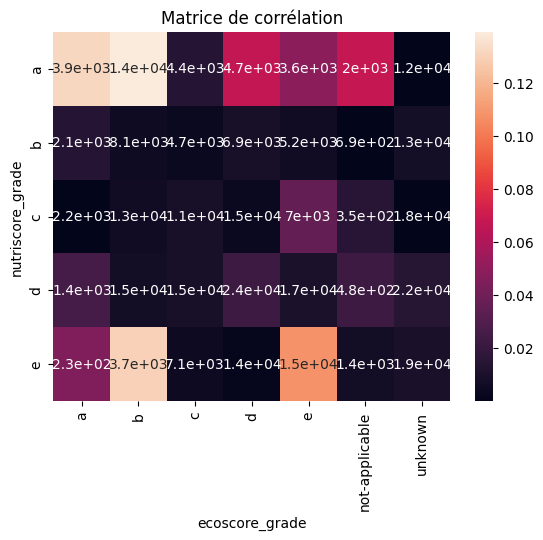

In [46]:
chi2('nutriscore_grade','ecoscore_grade',df_corr_qualenv,graph=True)

Interprétation : 
- 
- Fruit et légumes importés ecoscore important peuvent expliqué la présence notable d'une note d'ecoscore 'e' ou 'd' alors que le nutriscore sera de 'a'
